In [19]:
!pip install dabl

     |████████████████████████████████| 559 kB 1.7 MB/s eta 0:00:01
  Created wheel for dabl: filename=dabl-0.1.8-py3-none-any.whl size=565074 sha256=61aff6d3c56cfdb1dd1f0e6ed3e5a15a8725339663d3a56241bc487614f627e5
  Stored in directory: /home/kevinzhong/.cache/pip/wheels/6d/99/b3/c1bfea80b3baa5df9b1a1f91fcc29dbce50566a507e863eb69
Successfully built dabl


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dabl

%matplotlib inline

plt.style.use('ggplot')

In [3]:
df = pd.read_csv('StudentsPerformance.csv')

# EDA

In [4]:
df.head() # View the top few rows to have a quick look at what the data is like

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
df.info() # Look at how our data is structured

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [6]:
# Just making life easier when referencing column names
df.columns = df.columns.str.replace(" ", "_")

In [7]:
df.shape # How many rows do we have? 1000 tells us we're unlikely to have NaN

(1000, 8)

In [8]:
df.isnull().sum() # This confirms there is no missing data in our table

gender                         0
race/ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

In [9]:
df.describe() # What do our summary statistics look like? Do any of them look strange? Are there any outliers?
# Is there any missing data that's not a NaN?

,math_score,reading_score,writing_score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


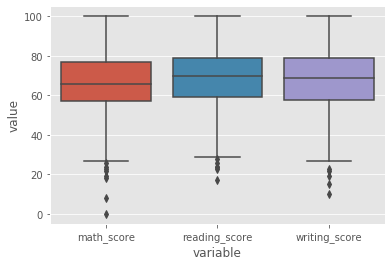

In [10]:
bx = sns.boxplot(x = 'variable', y = 'value', data = pd.melt(df[['math_score', 'reading_score', 'writing_score']]))

# Another look for any outliers - 0 for math might be worth looking at quickly

In [11]:
df['math_score'].value_counts() 

# One student scoring 0 is reasonable, so I won't delete

65    36
62    35
59    32
69    32
73    27
      ..
22     1
19     1
18     1
8      1
0      1
Name: math_score, Length: 81, dtype: int64

# Deeper Analysis - what variables are meaningful?

In this section we explore which of our variables would contribute to a machine learning model.

Our conclusion is that all variables add their own information.

In more complex analysis, it is worth further exploring multicollinearity of our predictor variables by looking at how closely they are correlated. However, this is difficult to do with confidence with categorical data with a small sample size.

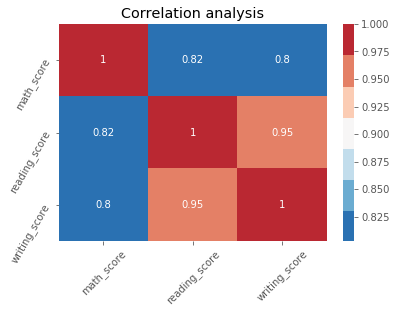

In [12]:
# All grades are highly correlated, with a particularly high correlation between writing and reading scores

cmap = sns.color_palette("RdBu_r", 7)
plt.figure()
plt.title('Correlation analysis')
sns.heatmap(df.corr(), cmap = cmap, annot = True)
plt.xticks(rotation = 45)
plt.yticks(rotation = 60)
plt.show()

Target looks like regression


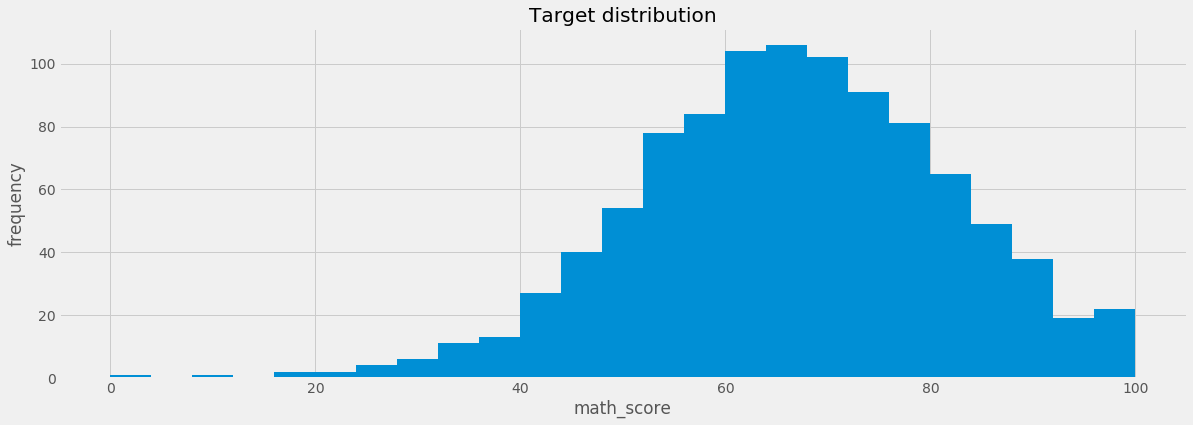

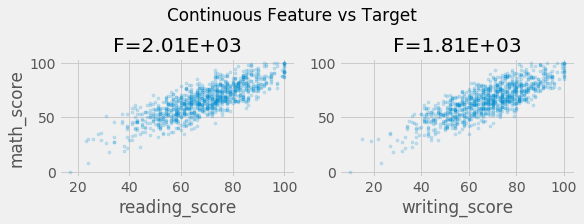

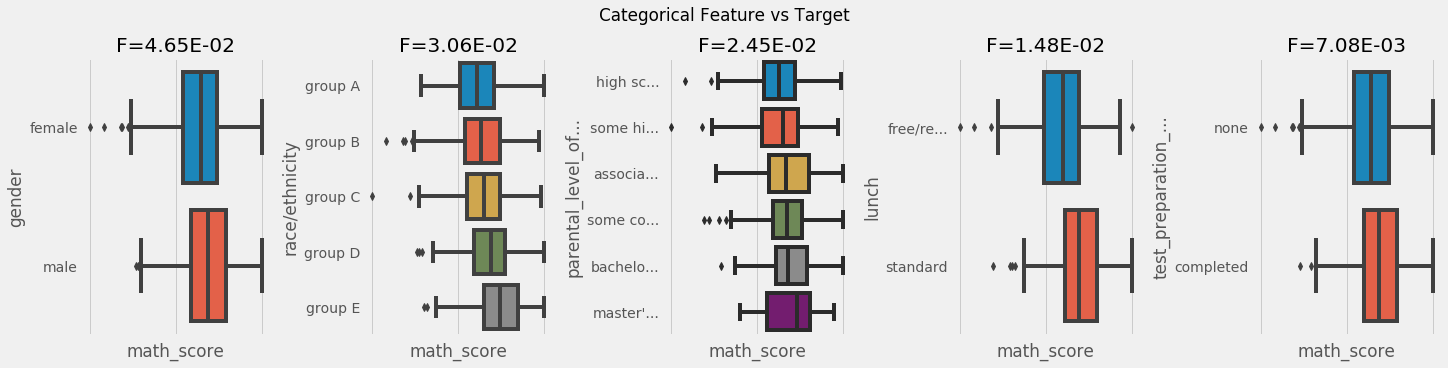

In [26]:
# comparison of all other attributes with respect to Math Marks
# Appears all features contribute to a student's marks
# Similar visualisations for Reading and Writing lead to the same conclusion

plt.rcParams['figure.figsize'] = (18, 6)
plt.style.use('fivethirtyeight')
dabl.plot(df, target_col = 'math_score')

# Building a model

## Rationale
* All features look to contribute to a student's marks. 
* However, all our predictor features are qualitative, making it difficult to predict a quantitative target, especially with our given sample size and number of features.
* Finally, all marks are highly correlated with each other.

For these reasons, we will look to build a model meant to estimate a students **mean** grade based on the following scale:

A: 90 - 100  
B: 80 - 89  
C: 70 - 79  
D: 60 - 69  
E: 50 - 59  
F: 0 - 49  

In future models, it may be worth exploring standardising our marks before creating an average, such that math marks do not dominate due to their higher mean.

In [56]:
# Importing relevant modules

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [52]:
# Splitting our data

X = df.drop(['math_score', 'reading_score', 'writing_score'], axis = 1)

def calcGrade(score):
    grades = [(90, 'A'),
             (80, 'B'),
             (70, 'C'),
             (60, 'D'),
             (50, 'E'),
             (0, 'F')]
    for i in grades:
        if score >= i[0]:
            return i[1]

y = df[['math_score', 'reading_score', 'writing_score']].sum(axis = 1)/3
y = y.apply(lambda x: calcGrade(x))

## Label Encoding

We will use an ordinal encoding on ordinal and binary predictor variables Gender, Parental Education, Lunch, and Test Preparation.

We will then use One-Hot encoding on the nominal feature Race/Ethnicity.

For more advanced models, it may be worth reconsidering our approach to how we encode parental education level (should an associate's degree be weighted twice as much as some high school?).

In [80]:
genders = ['female', 'male']
p_education = ["some high school", "high school", "associate's degree", "some college", "bachelor's degree", "master's degree"]
lunch = ["free/reduced", "standard"]
preparation = ['none', 'completed']

enc = preprocessing.OrdinalEncoder()
enc.fit(X.drop(['race/ethnicity'], axis = 1))

X_code = enc.transform(X.drop(['race/ethnicity'], axis = 1))

In [82]:
X[:10]

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course
0,female,group B,bachelor's degree,standard,none
1,female,group C,some college,standard,completed
2,female,group B,master's degree,standard,none
3,male,group A,associate's degree,free/reduced,none
4,male,group C,some college,standard,none
5,female,group B,associate's degree,standard,none
6,female,group B,some college,standard,completed
7,male,group B,some college,free/reduced,none
8,male,group D,high school,free/reduced,completed
9,female,group B,high school,free/reduced,none


In [81]:
X_code[:10]

array([[0., 1., 1., 1.],
       [0., 4., 1., 0.],
       [0., 3., 1., 1.],
       [1., 0., 0., 1.],
       [1., 4., 1., 1.],
       [0., 0., 1., 1.],
       [0., 4., 1., 0.],
       [1., 4., 0., 1.],
       [1., 2., 0., 0.],
       [0., 2., 0., 1.]])

In [51]:
fc = dabl.SimpleClassifier(random_state = 0)
fc.fit(X, y)

Running DummyClassifier(strategy='prior')
accuracy: 0.261 recall_macro: 0.167 precision_macro: 0.043 f1_macro: 0.069
=== new best DummyClassifier(strategy='prior') (using recall_macro):
accuracy: 0.261 recall_macro: 0.167 precision_macro: 0.043 f1_macro: 0.069

Running GaussianNB()
accuracy: 0.215 recall_macro: 0.264 precision_macro: 0.203 f1_macro: 0.199
=== new best GaussianNB() (using recall_macro):
accuracy: 0.215 recall_macro: 0.264 precision_macro: 0.203 f1_macro: 0.199

Running MultinomialNB()
accuracy: 0.291 recall_macro: 0.222 precision_macro: 0.313 f1_macro: 0.214
Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.106 recall_macro: 0.240 precision_macro: 0.039 f1_macro: 0.065
Running DecisionTreeClassifier(class_weight='balanced', max_depth=6)
accuracy: 0.179 recall_macro: 0.249 precision_macro: 0.189 f1_macro: 0.172
Running DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.01)
accuracy: 0.192 recall_macro: 0.259 precision_m

SimpleClassifier(random_state=0, refit=True, shuffle=True, type_hints=None,
                 verbose=1)

In [ ]:
fc.predict()

## A quick Lasso regression to check if there are any variables that don't contribute much

# The problem looks to be that all of the independent variables are categorical. It may be more valuable to do ANOVA.

# Specifically, Factorial ANOVA looks to be helpful.

## Note: Maybe a pipeline would help make this easier for the other subjects?
## Maybe we can use cross_val_score() instead of train_test_split() ?

### Next steps:
* Learn how to do Factorial ANOVA
* Create a pipeline for factorial ANOVA
* Apply that pipeline to all 3 scores

In [35]:
print(y_math)

     math_score
0            72
1            69
2            90
3            47
4            76
..          ...
995          88
996          62
997          59
998          68
999          77

[1000 rows x 1 columns]
